In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('five_minute.csv', parse_dates= ['time'], index_col= 'time')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73720 entries, 2019-01-01 22:00:00+00:00 to 2019-12-30 23:55:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   73720 non-null  float64
dtypes: float64(1)
memory usage: 1.1 MB


In [4]:
data.dropna(inplace=True)

In [5]:
data['returns'] = np.log(data.div(data.shift(1)))

In [6]:
lags = 5

In [7]:
cols = []
for lag in range(1, lags+1):
    col = 'lag{}'.format(lag)
    data[col] = data.returns.shift(lag)
    cols.append(col)
data.dropna(inplace= True)

In [8]:
cols

['lag1', 'lag2', 'lag3', 'lag4', 'lag5']

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
lm = LinearRegression(fit_intercept= True)

In [11]:
lm.fit(data[cols], data.returns)

LinearRegression()

In [12]:
lm.coef_ #slope

array([-0.03358358, -0.00243139,  0.00365238, -0.00366896, -0.00360391])

In [13]:
lm.intercept_

-3.2782924419950654e-07

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
data['predictions'] = lm.predict(data[cols].values)

In [16]:
data.predictions = np.sign(data.predictions)

In [17]:
data.predictions.value_counts()

-1.0    39610
 1.0    34104
Name: predictions, dtype: int64

In [18]:
data

,price,returns,lag1,lag2,lag3,lag4,lag5,predictions
time,,,,,,,,
2019-01-01 22:30:00+00:00,1.146455,-0.000017,-0.000048,0.000183,0.000000,-0.000026,-0.000201,1.0
2019-01-01 22:35:00+00:00,1.146455,0.000000,-0.000017,-0.000048,0.000183,0.000000,-0.000026,1.0
2019-01-01 22:40:00+00:00,1.146370,-0.000074,0.000000,-0.000017,-0.000048,0.000183,0.000000,-1.0
2019-01-01 22:45:00+00:00,1.146315,-0.000048,-0.000074,0.000000,-0.000017,-0.000048,0.000183,1.0
2019-01-01 22:50:00+00:00,1.146475,0.000140,-0.000048,-0.000074,0.000000,-0.000017,-0.000048,1.0
...,...,...,...,...,...,...,...,...
2019-12-30 23:35:00+00:00,1.120180,-0.000004,-0.000112,-0.000018,0.000022,-0.000004,0.000089,1.0
2019-12-30 23:40:00+00:00,1.120210,0.000027,-0.000004,-0.000112,-0.000018,0.000022,-0.000004,-1.0
2019-12-30 23:45:00+00:00,1.120295,0.000076,0.000027,-0.000004,-0.000112,-0.000018,0.000022,-1.0


In [19]:
hits = np.sign(data.predictions * data.returns).value_counts()
hits

 1.0    37493
-1.0    34263
 0.0     1958
dtype: int64

In [20]:
hit_ratio = hits[1.0]/sum(hits)
hit_ratio # percentage of correctly predicted market returns

0.5086279404183737

# In Sample Backtesting and look ahead bias

In [21]:
data['strategy'] = data.predictions * data.returns

In [22]:
data["creturns"] = data["returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)

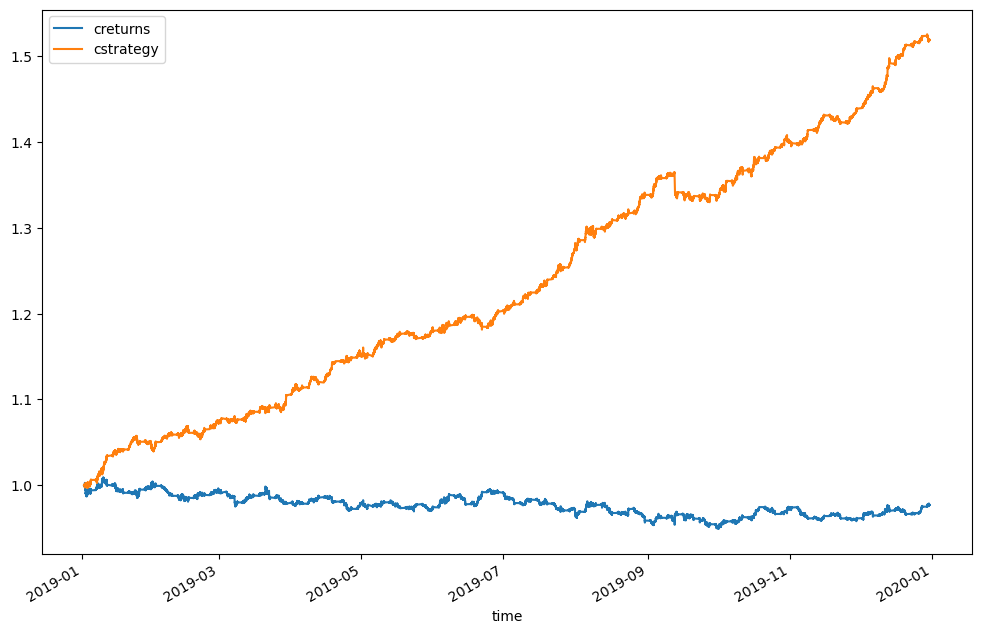

In [23]:
data[["creturns", "cstrategy"]].plot(figsize = (12 , 8))
plt.show()

In [24]:
data["trades"] = data.predictions.diff().fillna(0).abs()

In [25]:
data.trades.value_counts()

0.0    37100
2.0    36614
Name: trades, dtype: int64